In [1]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
sns.set_palette('Set2')
%matplotlib inline

# Get data

#### The data of Bitcoin/USD, we use joint URL in order to analyze the effect Ethereum later.

In [3]:
# API of Cryptographic currency in json format
url = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(url + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-03-22,69.87,73.75,65.00,70.85,73196.96,5171296.14
2013-03-23,64.35,70.50,52.35,69.87,150462.72,9429382.99
2013-03-24,71.50,72.50,62.70,64.35,42023.26,2896432.30
2013-03-25,73.60,78.00,69.52,71.50,79743.02,5921197.54
2013-03-26,78.50,79.72,73.11,73.60,56667.38,4377374.22


In [4]:
hist.tail()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-09-08,6200.16,6480.57,6134.76,6413.12,49719.12,3.173803e+08
2018-09-09,6249.07,6451.25,6161.83,6200.23,38701.00,2.444003e+08
2018-09-10,6324.43,6371.42,6247.64,6249.07,50695.88,3.204353e+08
2018-09-11,6295.54,6415.51,6199.19,6324.43,51401.22,3.245129e+08
2018-09-12,6291.50,6300.85,6229.40,6295.54,7054.84,4.433125e+07


#### Now set close price as target data, and later we will add price gap into model

In [5]:
target_col = 'close'

# Split training and test dataset

80% is used for training, 20% is used for testing.

In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)

# Data Visulization

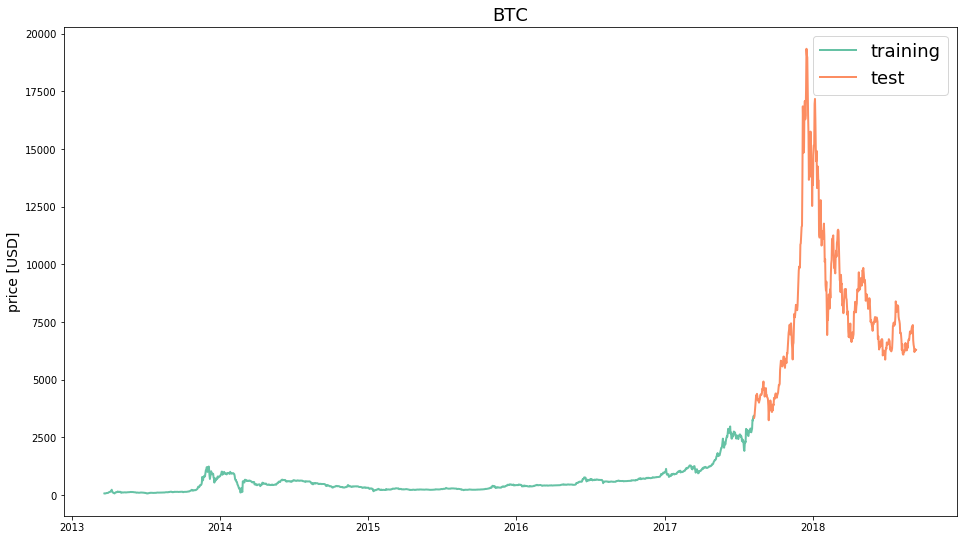

In [7]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

#### Have to consider that training data is all in lower price, but testing data is all in higher price, so it might be errors. 

# Build LSTM Model

#### Normalization

As the model does not ought to predict future price, but future change percentage.

In [15]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

#### smoothed data for average-7-days

In [16]:
def extract_window_data(df, window_len=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [17]:
def prepare_data(df, target_col, window_len=7, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

#### 1 layer LSTM model

In [18]:
# sigmoid is not as good as linear, as this data is one dimension and linear structure.
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    print (input_data.shape)
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [19]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [21]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

(1794, 7, 6)
Epoch 1/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0780
Epoch 2/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0542
Epoch 3/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0502
Epoch 4/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0464
Epoch 5/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0435
Epoch 6/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0431
Epoch 7/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0417
Epoch 8/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0402
Epoch 9/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0411
Epoch 10/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0395
Epoch 11/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0396
Epoch 12/50
1794/1794 [==============================] - 4s 2ms/step - l

# Prediction

In [33]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [34]:
# mean_absolute_error(preds, y_test)

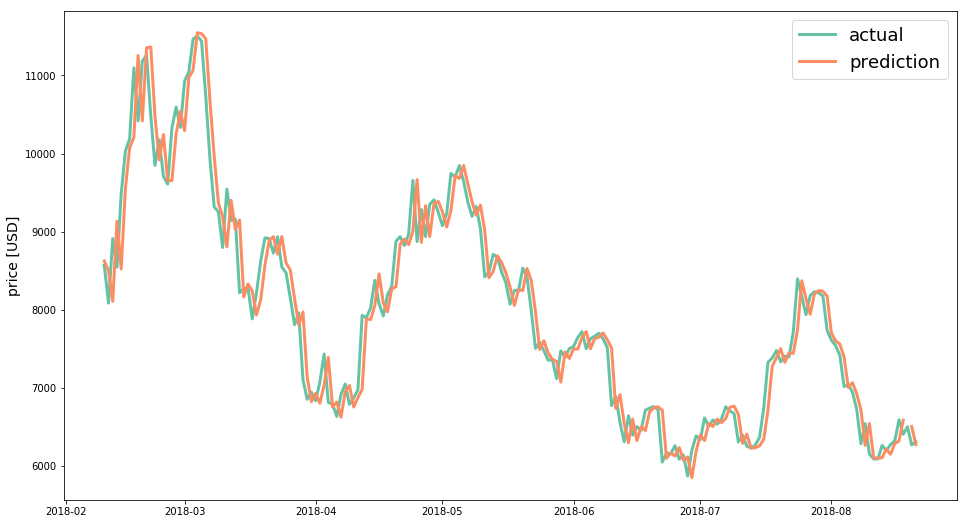

In [35]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

#### Drill down data

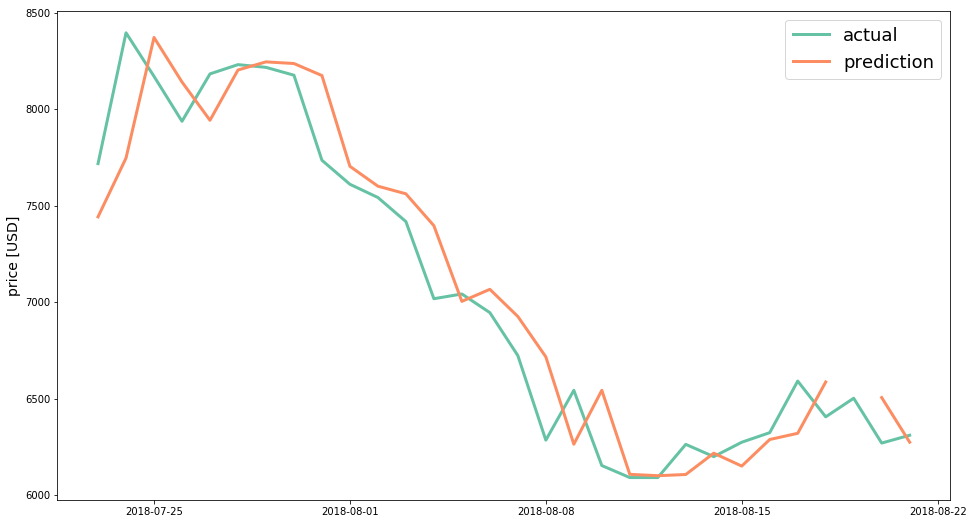

In [36]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

#### Though the predictions look like super precise, However, we could find that the predicted data is the same as previous actual data. 

good documentation 
http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction

In [1]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [2]:
# Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, X_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)

NameError: name 'lstm' is not defined

### Shift one day to further analyzed.

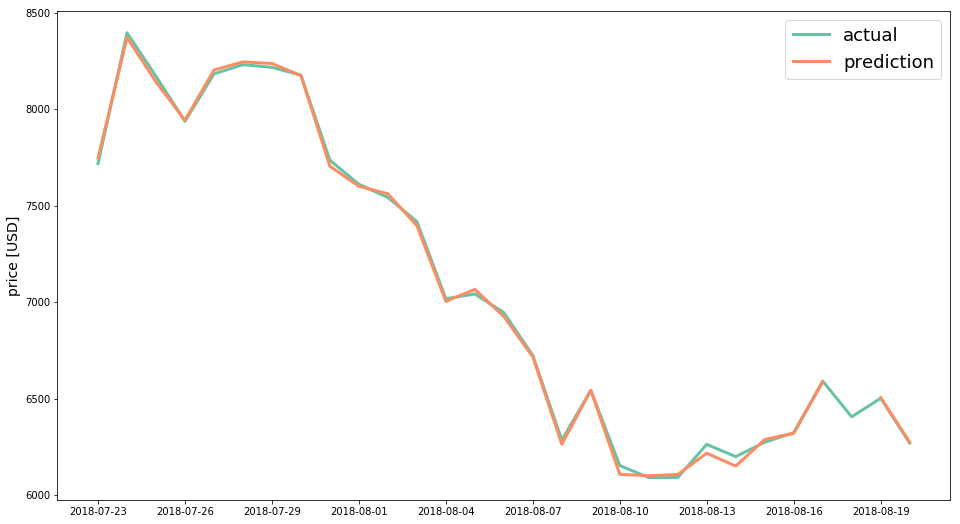

In [37]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)

### Correlation test

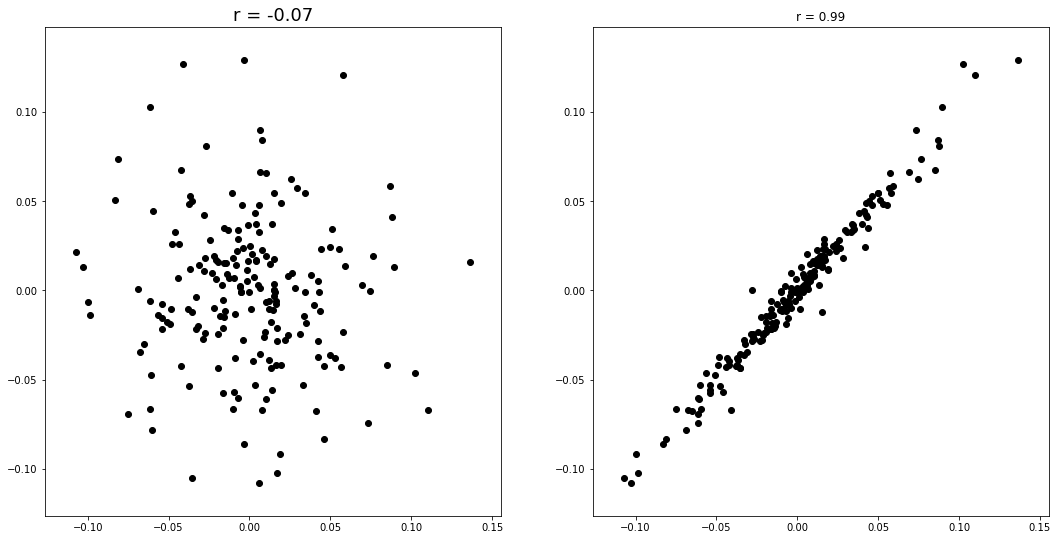

In [39]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k')
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)
# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k')
ax2.set_title('r = {:.2f}'.format(corr));

After predicted price is shifted one day back, the correlation is 0.98, almost 1, which means the prediced price is the same as previous day actual price.

In conclusion, this basic model is not practical at all.

### Next step, predict future price based on more timepoints other than only one timepoint.